In [1]:
import pandas as pd
import numpy as np
import requests

### Key observations on these relationships

- Data utilized for training: $4$ years worth half-hourly national demand and prices sourced from UK historical demand page and elexon
- Data was also scaled using minmax scaler to maintain a sensible matrix for inversion
- Note that this is an exploratory analysis whose intention is to figure out if there is a sensible linear model which can fit properties like prices and intraday volatility against demand. To simplify things, I only used the national demand which can be extended with other factors like Interconnector flows, capacity etc for a more extensive approach
- Starting off, the time series regression do make sense as the ADF test says that we are not having unit roots in residuals implying that the residuals aren't random walks. 
- While the $R^{2}$ scores are low, AIC/BIC are negative implying a fair amount of positive likelihood(Regression stats are available)
- Some preprocessing I did was to remove trend/seasonality from demand / prices / vol as they had very low DW statistic implying lot of residual autocorrelation. To make forecasts on forecasted demand in future, one can remove trend/seasonality, predict using the model and add these properties back. My intention was to focus on a more generic relationship between demands and clearing prices as rest of the signals are systematic noise
- Considering the demand created by EV / residential heating, we can formulate $D_{adj} = D + f(EV,Res_{heat})$ which can mean that the prices would increase when a certain amount of the demand is driven orthogonally from the existing demand values
- However, a thing which was strange was that the overall ND was reducing over time which felt counterintuitive but could be due to the amount of outflow happening through interconnectors
- As for intraday volatility, unless $f(EV,Res_{heat})$ follows a very volatile model, I wouldn't expect it to increase as much compared to that of prices due to the low demand loading.
- A much more extensive analysis can be performed when only certain hours are shocked instead of all hours, which can effect prices significantly but would expect the impact to be lower for intraday vol as its a metric across the whole day which would lead to averaged out effect
- Summarizing, in short term, I would expect the prices and vols to increase, prices specifically but vol not as much. As someone who trades short term power, I would think cobblestone does get impacted by this in auctions and should adjust theoretical prices accordingly to maximize profits
- Below pages have plots which you can refer to, only two online resources I used were https://www.nationalgrideso.com/data-portal/historic-demand-data for demand data and elexon for prices

### Extensions

- Slightly complicated model for demand on EV / heating would be better to work with. I have tried to find some relevant material under the time constraint but most of the research seemed to focus on psychological aspect of EV taking off which involved forms/surveys
- Maybe we can draw a parallel to US adoptions and see if any inference can be made. I initially was opposed to doing this as the demographics are very different
- Obviously linear regression isn't the best model to pinpoint the impact but is a very good starter to get an idea of impact direction and magnitude. We can try using a random forest/XGBoost by decomposing trend/seasonality, use various components of demand and make a complex model which can accurately estimate the price/vol impact. I stuck to OLS because of the interpretability 

In [2]:
path = "historical_demand/demanddata_"
years = np.linspace(2021,2024,16,dtype = "int")
demand_data = []
for year in years:
    demand_data.append(pd.read_csv(path+str(year)+".csv"))
demand_df = pd.concat(demand_data)
demand_df = demand_df.fillna(0)
demand_df = demand_df.set_index("SETTLEMENT_DATE")

In [3]:
def custom_date_parser(date_string):
    try:
        # Try parsing in the format 'DD-MMM-YYYY'
        return pd.to_datetime(date_string, format='%d-%b-%Y')
    except ValueError:
        try:
            # If that fails, try parsing in the format 'YYYY-MM-DD'
            return pd.to_datetime(date_string, format='%Y-%m-%d')
        except ValueError:
            # If both fail, return NaT (Not a Time)
            return pd.NaT

def convert_index(df):
    df.index = df.index.map(custom_date_parser)
    df['time'] = pd.to_timedelta((df['SETTLEMENT_PERIOD'] - 1) * 30, unit='m')
    df.index = df.index + df['time']
    df = df.drop(['time', 'SETTLEMENT_PERIOD'], axis=1)
    return df

def get_prices(start,end):
    url = f"https://data.elexon.co.uk/bmrs/api/v1/datasets/MID?from={start}T00%3A00Z&to={end}T00%3A00Z&dataProviders=APXMIDP"
    response = requests.get(url)
    data = response.json()
    prices_df = pd.json_normalize(data["data"])
    prices_df = prices_df.set_index("settlementDate")
    prices_df.rename(columns={
    'settlementPeriod': 'SETTLEMENT_PERIOD',
    }, inplace=True)
    prices_df = convert_index(prices_df)
    prices_df = prices_df.sort_index()
    return prices_df

In [4]:
demand_df = convert_index(demand_df)

In [5]:
demand_df["days"] = demand_df.index.date

In [6]:
#req_dates = np.unique(demand_df["days"].to_numpy())
#prices_list = []
#for i in range(1229,len(req_dates) - 6):
#    prices_list.append(get_prices(req_dates[i], req_dates[i+6]))
#prices_df = pd.concat(prices_list)
#prices_df.to_csv("Historical_prices")

In [7]:
prices_df = pd.read_csv("Historical_prices.csv")
prices_df.rename(columns={'Unnamed: 0': 'SETTLEMENT_DATE'}, inplace=True)
prices_df = prices_df.set_index("SETTLEMENT_DATE")
prices_df.index = pd.to_datetime(prices_df.index) 
prices_df.index.name = None

In [8]:
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose

X = demand_df["ND"] ## restricting to total national demand, can be extended
X = X[~X.index.duplicated(keep='first')]
y = prices_df["price"]## ignoring volume for now, can be considered for future
y = y[~y.index.duplicated(keep='first')]
common_indices = X.index.intersection(y.index)
filtered_X = X.loc[common_indices]
filtered_y = y.loc[common_indices]
new_index = pd.date_range(start=common_indices.min(), end=common_indices.max(), freq='30min')
filtered_X = filtered_X.reindex(new_index)
filtered_y = filtered_y.reindex(new_index)

filtered_X = filtered_X.interpolate(method='time')
filtered_y = filtered_y.interpolate(method='time')

In [9]:
def OLS_fit(X,y):
    X = (X - X.min())/(X.max() - X.min())
    y = (y - y.min())/(y.max() - y.min())
    X_intercept = sm.add_constant(X.to_numpy())
    # Create the OLS model instance
    model = sm.OLS(y.to_numpy(), X_intercept)
    # Fit the model
    OLS_fit = model.fit()
    # Print the summary of the model
    print(OLS_fit.summary())
    residuals = OLS_fit.resid
    # Plot ACF of residuals
    plot_acf(residuals, lags=40)
    plt.title('ACF of Residuals')
    plt.show()
    result = adfuller(residuals)
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')

def seasonal_decomp(data, plot=False):
    # Assuming 'data' is a pandas Series with a DateTime index
    decomposition = seasonal_decompose(data, model='additive', period = 48)
    if plot:
        plt.figure(figsize = (3,3))
        decomposition.plot()
        plt.show()
    return decomposition

### Analysis 

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.088
Model:                            OLS   Adj. R-squared:                  0.088
Method:                 Least Squares   F-statistic:                     6058.
Date:                Mon, 19 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:23:31   Log-Likelihood:             1.6119e+05
No. Observations:               62451   AIC:                        -3.224e+05
Df Residuals:                   62449   BIC:                        -3.224e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2274      0.000    895.216      0.0

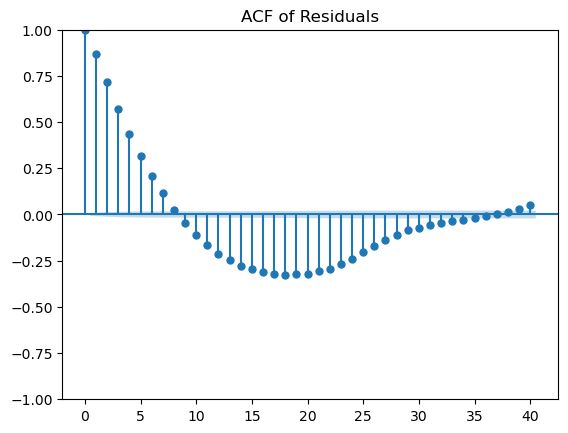

ADF Statistic: -54.84722149994893
p-value: 0.0


In [10]:
decomp_X = seasonal_decomp(filtered_X)
decomp_y = seasonal_decomp(filtered_y)
X_req = decomp_X.resid.dropna()
y_req = decomp_y.resid.dropna()
OLS_fit(X_req,y_req)

In [11]:
data_df = pd.DataFrame()
data_df["ND"] = filtered_X
data_df["Price"] = filtered_y

### On data grouped to a daily granularity

In [12]:
daily_data = data_df.resample('D').agg({
    'ND': 'mean', 
    'Price': ['mean', 'std']
})
daily_data.columns = ['Demand_avg', 'Price_avg', "Daily_vol"]

<Figure size 300x300 with 0 Axes>

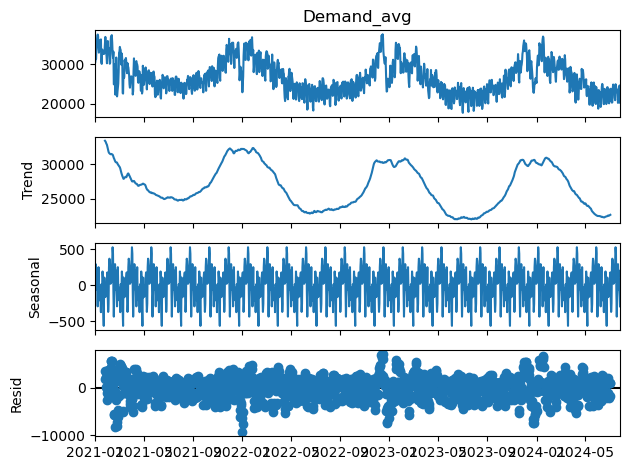

<Figure size 300x300 with 0 Axes>

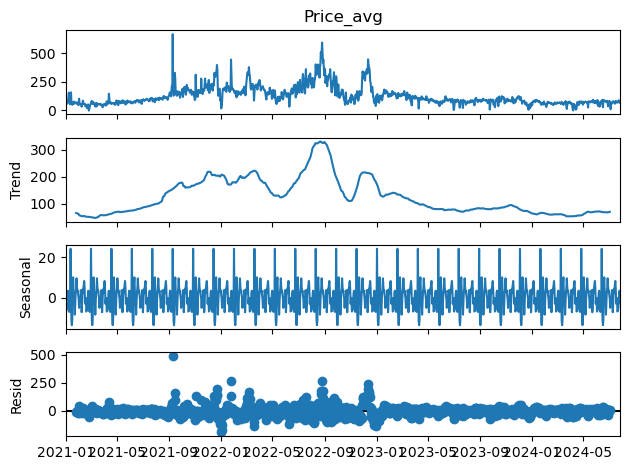

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.264
Model:                            OLS   Adj. R-squared:                  0.263
Method:                 Least Squares   F-statistic:                     448.3
Date:                Mon, 19 Aug 2024   Prob (F-statistic):           2.63e-85
Time:                        19:23:39   Log-Likelihood:                 1879.2
No. Observations:                1255   AIC:                            -3754.
Df Residuals:                    1253   BIC:                            -3744.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1539      0.006     24.700      0.0

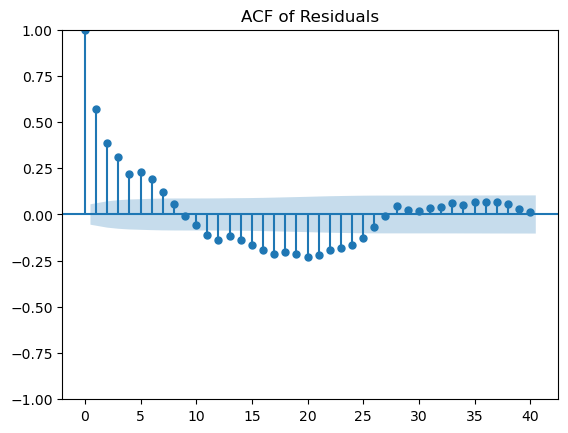

ADF Statistic: -10.844320876688789
p-value: 1.5865945477557885e-19


In [13]:
decomp_X = seasonal_decomp(daily_data["Demand_avg"], plot = True)
decomp_y = seasonal_decomp(daily_data["Price_avg"], plot = True)
X_req = decomp_X.resid.dropna()
y_req = decomp_y.resid.dropna()
OLS_fit(X_req,y_req)

<Figure size 300x300 with 0 Axes>

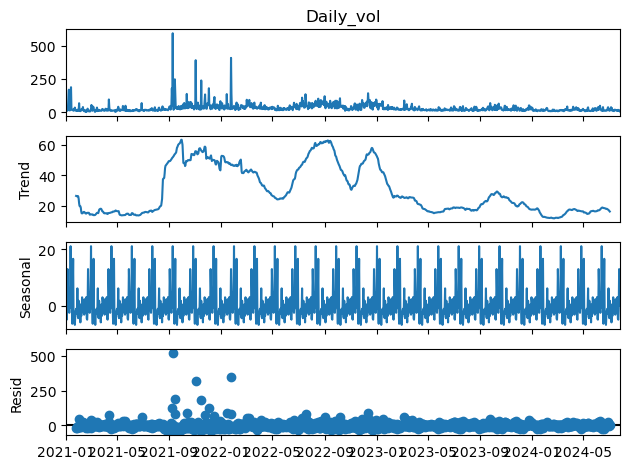

                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.008
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     10.14
Date:                Mon, 19 Aug 2024   Prob (F-statistic):            0.00149
Time:                        19:23:41   Log-Likelihood:                 2041.1
No. Observations:                1255   AIC:                            -4078.
Df Residuals:                    1253   BIC:                            -4068.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0609      0.005     11.115      0.0

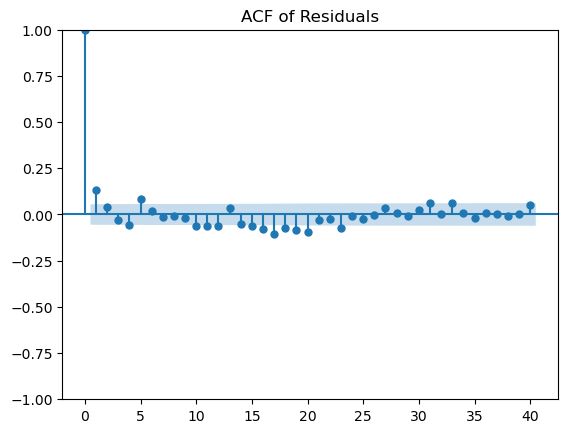

ADF Statistic: -11.90660994033187
p-value: 5.417569099155691e-22


In [14]:
decomp_X = seasonal_decomp(daily_data["Demand_avg"], plot = False)
decomp_y = seasonal_decomp(daily_data["Daily_vol"], plot = True)
X_req = decomp_X.resid.dropna()
y_req = decomp_y.resid.dropna()
OLS_fit(X_req,y_req)